In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [3]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

# My Model

In [65]:
# Feel free to play with this cell

def my_model(X,y,is_training):
    Wconv1 = tf.get_variable("Wconv1", shape=[5, 5, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])

    Wconv2 = tf.get_variable("Wconv2", shape=[5, 5, 32, 64])
    bconv2 = tf.get_variable("bconv2", shape=[64])

    Wconv3 = tf.get_variable("Wconv3", shape=[5, 5, 64, 64])
    bconv3 = tf.get_variable("bconv3", shape=[64])

    Wconv4 = tf.get_variable("Wconv4", shape=[5, 5, 32, 32])
    bconv4 = tf.get_variable("bconv4", shape=[32])

    Wconv5 = tf.get_variable("Wconv5", shape=[3, 3, 64, 64])
    bconv5 = tf.get_variable("bconv5", shape=[64])

    Wconv6 = tf.get_variable("Wconv6", shape=[3, 3, 64, 64])
    bconv6 = tf.get_variable("bconv6", shape=[64])

    W1 = tf.get_variable("W1", shape=[4*4*64,10])
    b1 = tf.get_variable("b1", shape=[10])

    # CONV RELU CONV RELU MAX_POOLING
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1, 1, 1, 1], padding='SAME') + bconv1
    a1 = tf.contrib.layers.batch_norm(a1, center=True, scale=True, is_training=is_training)
    h1 = tf.nn.relu(a1)
    a1 = tf.nn.conv2d(h1, Wconv4, strides=[1,1,1,1], padding='SAME') + bconv4
    a1 = tf.contrib.layers.batch_norm(a1, center=True, scale=True, is_training=is_training)
    h1 = tf.nn.relu(a1)
    h1 = tf.nn.max_pool(h1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID') # 16x16x32

    a1 = tf.nn.conv2d(h1, Wconv2, strides=[1,1,1,1], padding='SAME') + bconv2
    a1 = tf.contrib.layers.batch_norm(a1, center=True, scale=True, is_training=is_training)
    h1 = tf.nn.relu(a1)
    a1 = tf.nn.conv2d(h1, Wconv5, strides=[1,1,1,1], padding='SAME') + bconv5
    a1 = tf.contrib.layers.batch_norm(a1, center=True, scale=True, is_training=is_training)
    h1 = tf.nn.relu(a1)
    h1 = tf.nn.max_pool(h1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID') # 8x8x64

    a1 = tf.nn.conv2d(h1, Wconv3, strides=[1,1,1,1], padding='SAME') + bconv3 
    a1 = tf.contrib.layers.batch_norm(a1, center=True, scale=True, is_training=is_training)
    h1 = tf.nn.relu(a1)
    a1 = tf.nn.conv2d(h1, Wconv6, strides=[1,1,1,1], padding='SAME') + bconv6 # 4 * 4 * 64
    a1 = tf.contrib.layers.batch_norm(a1, center=True, scale=True, is_training=is_training)
    h1 = tf.nn.relu(a1)
    h1 = tf.nn.max_pool(h1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID') # 4x4x64
    
    h1_flat = tf.reshape(h1,[-1,4*4*64])
    y_out = tf.matmul(h1_flat,W1) + b1
    
    return y_out

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)

total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

optimizer = tf.train.RMSPropOptimizer(learning_rate=1e-3)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

# Run my_model

Training
Iteration 0: with minibatch training loss = 3.23 and accuracy of 0.11
Iteration 100: with minibatch training loss = 1.58 and accuracy of 0.45
Iteration 200: with minibatch training loss = 1.71 and accuracy of 0.42
Iteration 300: with minibatch training loss = 1.31 and accuracy of 0.52
Iteration 400: with minibatch training loss = 1.42 and accuracy of 0.45
Iteration 500: with minibatch training loss = 1.34 and accuracy of 0.48
Iteration 600: with minibatch training loss = 0.788 and accuracy of 0.69
Iteration 700: with minibatch training loss = 0.865 and accuracy of 0.7
Epoch 1, Overall loss = 1.39 and accuracy of 0.505


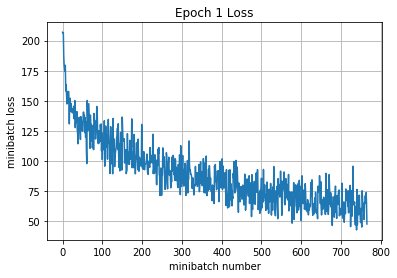

Iteration 800: with minibatch training loss = 0.667 and accuracy of 0.83
Iteration 900: with minibatch training loss = 0.817 and accuracy of 0.7
Iteration 1000: with minibatch training loss = 0.796 and accuracy of 0.75
Iteration 1100: with minibatch training loss = 0.764 and accuracy of 0.73
Iteration 1200: with minibatch training loss = 0.863 and accuracy of 0.67
Iteration 1300: with minibatch training loss = 0.638 and accuracy of 0.72
Iteration 1400: with minibatch training loss = 0.877 and accuracy of 0.75
Iteration 1500: with minibatch training loss = 0.684 and accuracy of 0.77
Epoch 2, Overall loss = 0.828 and accuracy of 0.707


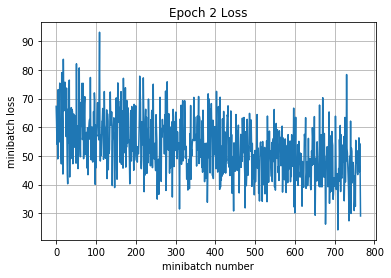

Iteration 1600: with minibatch training loss = 0.838 and accuracy of 0.69
Iteration 1700: with minibatch training loss = 0.598 and accuracy of 0.72
Iteration 1800: with minibatch training loss = 0.733 and accuracy of 0.78
Iteration 1900: with minibatch training loss = 0.538 and accuracy of 0.78
Iteration 2000: with minibatch training loss = 0.829 and accuracy of 0.75
Iteration 2100: with minibatch training loss = 0.779 and accuracy of 0.73
Iteration 2200: with minibatch training loss = 0.516 and accuracy of 0.86
Epoch 3, Overall loss = 0.641 and accuracy of 0.776


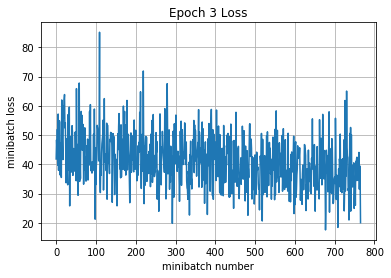

Iteration 2300: with minibatch training loss = 0.557 and accuracy of 0.8
Iteration 2400: with minibatch training loss = 0.517 and accuracy of 0.84
Iteration 2500: with minibatch training loss = 0.475 and accuracy of 0.81
Iteration 2600: with minibatch training loss = 0.563 and accuracy of 0.83
Iteration 2700: with minibatch training loss = 0.391 and accuracy of 0.86
Iteration 2800: with minibatch training loss = 0.407 and accuracy of 0.86
Iteration 2900: with minibatch training loss = 0.603 and accuracy of 0.81
Iteration 3000: with minibatch training loss = 0.946 and accuracy of 0.69
Epoch 4, Overall loss = 0.518 and accuracy of 0.821


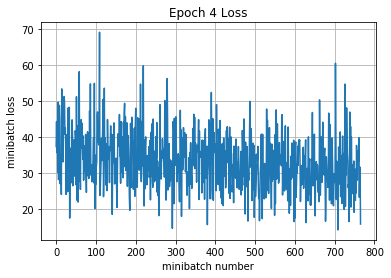

Iteration 3100: with minibatch training loss = 0.52 and accuracy of 0.78
Iteration 3200: with minibatch training loss = 0.525 and accuracy of 0.83
Iteration 3300: with minibatch training loss = 0.463 and accuracy of 0.83
Iteration 3400: with minibatch training loss = 0.411 and accuracy of 0.81
Iteration 3500: with minibatch training loss = 0.674 and accuracy of 0.78
Iteration 3600: with minibatch training loss = 0.556 and accuracy of 0.88
Iteration 3700: with minibatch training loss = 0.418 and accuracy of 0.89
Iteration 3800: with minibatch training loss = 0.215 and accuracy of 0.91
Epoch 5, Overall loss = 0.419 and accuracy of 0.856


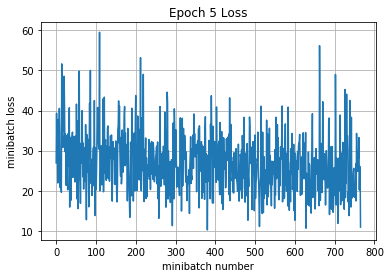

Iteration 3900: with minibatch training loss = 0.308 and accuracy of 0.91
Iteration 4000: with minibatch training loss = 0.395 and accuracy of 0.91
Iteration 4100: with minibatch training loss = 0.381 and accuracy of 0.83
Iteration 4200: with minibatch training loss = 0.399 and accuracy of 0.89
Iteration 4300: with minibatch training loss = 0.276 and accuracy of 0.94
Iteration 4400: with minibatch training loss = 0.242 and accuracy of 0.94
Iteration 4500: with minibatch training loss = 0.528 and accuracy of 0.83
Epoch 6, Overall loss = 0.337 and accuracy of 0.885


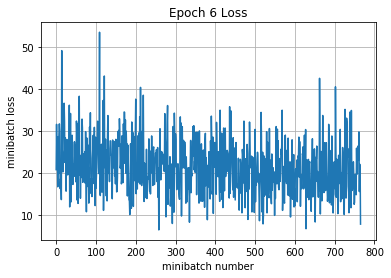

Iteration 4600: with minibatch training loss = 0.197 and accuracy of 0.94
Iteration 4700: with minibatch training loss = 0.315 and accuracy of 0.84
Iteration 4800: with minibatch training loss = 0.221 and accuracy of 0.95
Iteration 4900: with minibatch training loss = 0.189 and accuracy of 0.94
Iteration 5000: with minibatch training loss = 0.301 and accuracy of 0.91
Iteration 5100: with minibatch training loss = 0.215 and accuracy of 0.94
Iteration 5200: with minibatch training loss = 0.225 and accuracy of 0.92
Iteration 5300: with minibatch training loss = 0.196 and accuracy of 0.94
Epoch 7, Overall loss = 0.266 and accuracy of 0.911


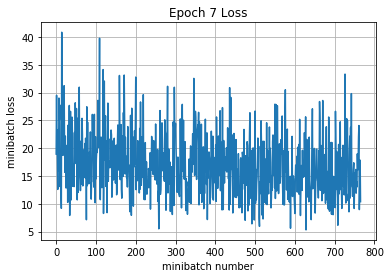

Iteration 5400: with minibatch training loss = 0.162 and accuracy of 0.94
Iteration 5500: with minibatch training loss = 0.288 and accuracy of 0.86
Iteration 5600: with minibatch training loss = 0.178 and accuracy of 0.92
Iteration 5700: with minibatch training loss = 0.308 and accuracy of 0.91
Iteration 5800: with minibatch training loss = 0.149 and accuracy of 0.94
Iteration 5900: with minibatch training loss = 0.157 and accuracy of 0.94
Iteration 6000: with minibatch training loss = 0.126 and accuracy of 0.97
Iteration 6100: with minibatch training loss = 0.298 and accuracy of 0.92
Epoch 8, Overall loss = 0.209 and accuracy of 0.93


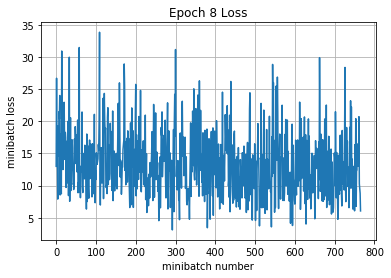

Iteration 6200: with minibatch training loss = 0.194 and accuracy of 0.95
Iteration 6300: with minibatch training loss = 0.314 and accuracy of 0.89
Iteration 6400: with minibatch training loss = 0.097 and accuracy of 0.98
Iteration 6500: with minibatch training loss = 0.188 and accuracy of 0.95
Iteration 6600: with minibatch training loss = 0.343 and accuracy of 0.89
Iteration 6700: with minibatch training loss = 0.222 and accuracy of 0.92
Iteration 6800: with minibatch training loss = 0.154 and accuracy of 0.95
Epoch 9, Overall loss = 0.17 and accuracy of 0.943


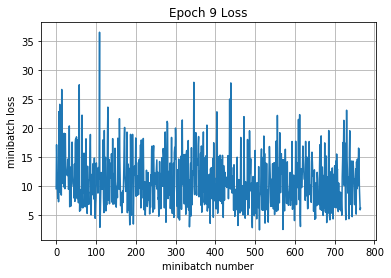

Iteration 6900: with minibatch training loss = 0.0992 and accuracy of 0.95
Iteration 7000: with minibatch training loss = 0.213 and accuracy of 0.89
Iteration 7100: with minibatch training loss = 0.0778 and accuracy of 1
Iteration 7200: with minibatch training loss = 0.0969 and accuracy of 0.95
Iteration 7300: with minibatch training loss = 0.1 and accuracy of 0.97
Iteration 7400: with minibatch training loss = 0.128 and accuracy of 0.95
Iteration 7500: with minibatch training loss = 0.0642 and accuracy of 0.97
Iteration 7600: with minibatch training loss = 0.121 and accuracy of 0.94
Epoch 10, Overall loss = 0.141 and accuracy of 0.952


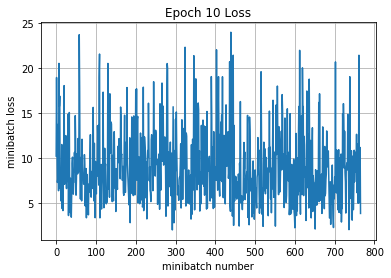

Validation
Epoch 1, Overall loss = 1.26 and accuracy of 0.762


(1.2637081003189088, 0.76200000000000001)

In [66]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [67]:
### Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.655 and accuracy of 0.832
Validation
Epoch 1, Overall loss = 1.26 and accuracy of 0.762


(1.2637080898284911, 0.76200000000000001)

In [68]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

sess.close()

Test
Epoch 1, Overall loss = 1.46 and accuracy of 0.737
